In [134]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns

import allen_v1dd.stimulus_analysis.analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups, get_roi_id
from allen_v1dd.stimulus_analysis import fit_utils

at.set_stylesheet()
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v2.h5")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fraction DG responsive by depth

In [133]:
np.max(np.random.randn(10, 2), axis=1)

array([1.66087962, 1.73555484])

In [140]:
tuning_params.shape

(3178, 2, 6)

In [155]:
df = []

for group in iter_plane_groups(filter=dict(column=[2, 3, 4, 5])):
    rois = np.where(group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()])[0]
    mouse, column, depth = group.attrs["mouse"], group.attrs["column"], group.attrs["plane_depth_microns"]

    for dg_type in ("windowed", "full"):
        dg = group[f"drifting_gratings_{dg_type}"]
        frac_resp = dg["frac_responsive_trials"][()]
        tuning_r2 = dg["tuning_curve_r2"][()]
        tuning_params = dg["tuning_curve_params"][()]
        pref_sf_idx = dg["pref_cond_index"][:, 1]
        
        for roi in rois:
            sf_i = pref_sf_idx[roi]
            p = tuning_params[roi, sf_i] # scale_1, k_1, x0, scale_2, k2, bz

            df.append(dict(
                mouse = mouse,
                column = column,
                depth = depth,
                roi = roi,
                dg_type = dg_type,
                is_responsive = frac_resp[roi] >= 0.5,
                tuning_r2 = tuning_r2[roi, sf_i],
                tuning_sharpness = fit_utils.vonmises_two_peak_get_sharpness(p),
                tuning_k = fit_utils.vonmises_two_peak_get_peak_k(p)
            ))

df = pd.DataFrame(df)
df

,mouse,column,depth,roi,dg_type,is_responsive,tuning_r2,tuning_sharpness,tuning_k
0,409828,2,50,0,windowed,True,0.653741,0.886349,4.420602e-05
1,409828,2,50,1,windowed,True,0.070825,0.023740,3.893664e-13
2,409828,2,50,4,windowed,True,0.784705,0.757201,2.001858e-06
3,409828,2,50,149,windowed,True,0.121678,0.021506,1.470847e-16
4,409828,2,50,0,full,True,0.241367,0.316141,2.061434e-03
...,...,...,...,...,...,...,...,...,...
169431,438833,5,514,195,full,False,0.062152,0.065794,2.345354e-06
169432,438833,5,514,212,full,False,0.538785,0.295316,4.093394e-04
169433,438833,5,514,218,full,False,0.281321,0.093416,1.057648e-06
169434,438833,5,514,224,full,False,0.522434,0.696505,2.727706e-05


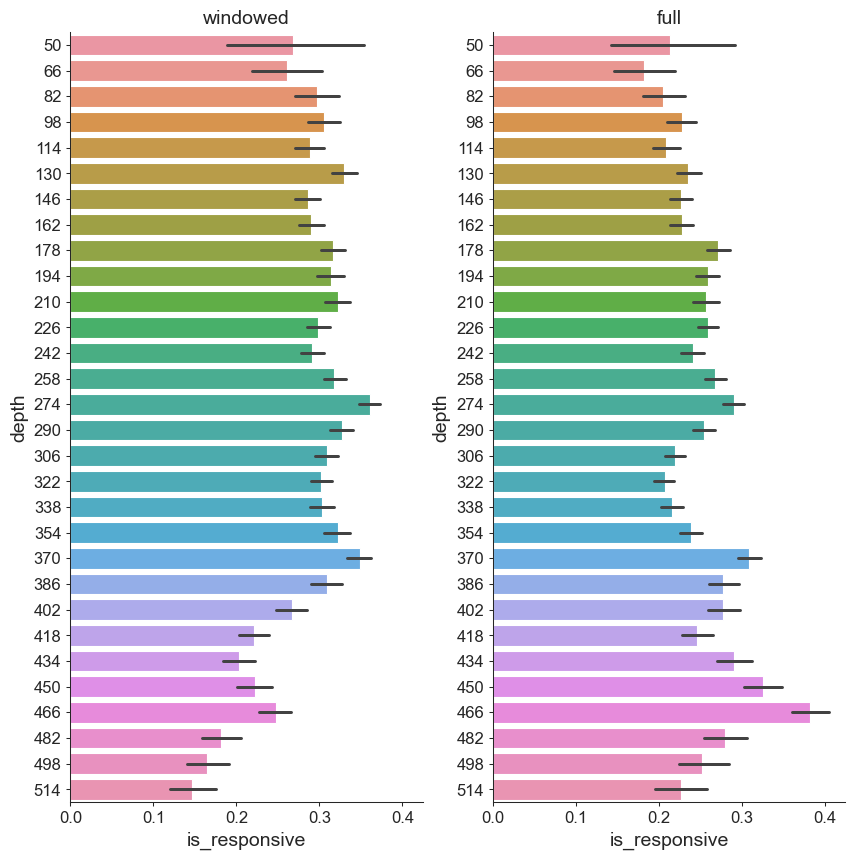

In [26]:
fig, axs = plt.subplots(figsize=(10, 10), ncols=2, sharex=True)

for ax, dg_type in zip(axs, ("windowed", "full")):
    sns.barplot(data=df[df.dg_type == dg_type], x="is_responsive", y="depth", orient="horizontal", ax=ax)
    ax.set_title(dg_type)

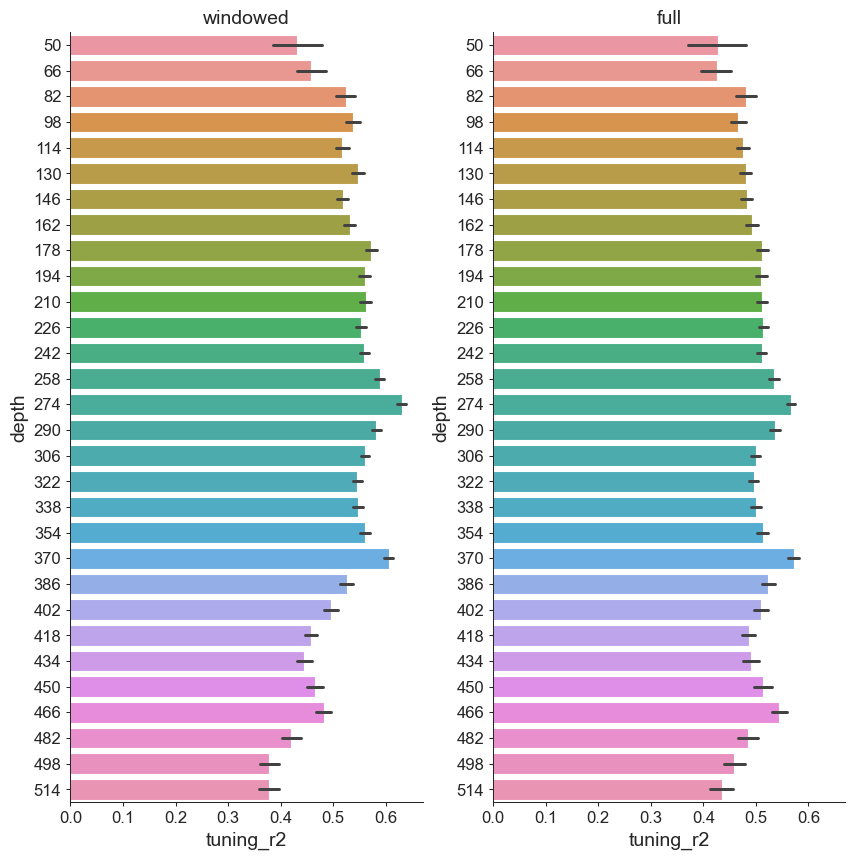

In [144]:
fig, axs = plt.subplots(figsize=(10, 10), ncols=2, sharex=True)

for ax, dg_type in zip(axs, ("windowed", "full")):
    sns.barplot(data=df[df.dg_type == dg_type], x="tuning_r2", y="depth", orient="horizontal", ax=ax)
    ax.set_title(dg_type)

In [135]:
def horiz_point_plot_ci(df, x, y, hue, ax, n_boot=1000):
    df_conf = df.groupby([hue, y]).aggregate(
        x = pd.NamedAgg(x, "mean"),
        ci = pd.NamedAgg(x, lambda data: tuple(sns.utils.ci(sns.algorithms.bootstrap(data.astype(float), n_boot=n_boot))))
    )
    df_conf = df_conf.reset_index()
    
    for hue_val in df_conf[hue].unique():
        df_sub = df_conf[df_conf[hue] == hue_val]

        x_vals = df_sub["x"].values
        y_vals = df_sub[y].values
        ci = np.vstack(df_sub["ci"].values).T
        ci[0] = x_vals - ci[0] # lower error, relative to mean
        ci[1] = ci[1] - x_vals # upper error

        ax.errorbar(x=x_vals, y=y_vals, xerr=ci, label=hue_val, marker=".", markersize=10)
    
    ax.legend(title=hue)
        

Text(0, 0.5, 'Depth (µm)')

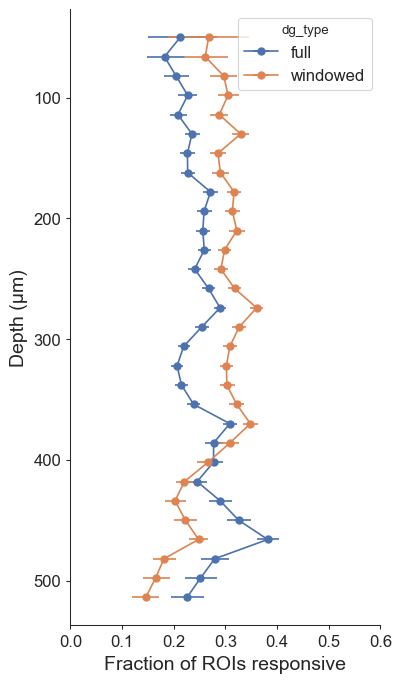

In [145]:
fig, ax = plt.subplots(figsize=(4, 8))

horiz_point_plot_ci(df, x="is_responsive", y="depth", hue="dg_type", ax=ax)

ax.set_xlim(0, 0.6)
ax.invert_yaxis()
ax.set_xlabel("Fraction of ROIs responsive")
ax.set_ylabel("Depth (µm)")

<Axes: >

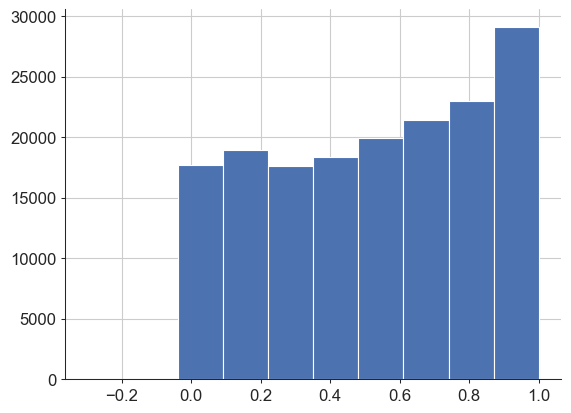

In [148]:
df.tuning_r2.hist()

Text(0, 0.5, 'Depth (µm)')

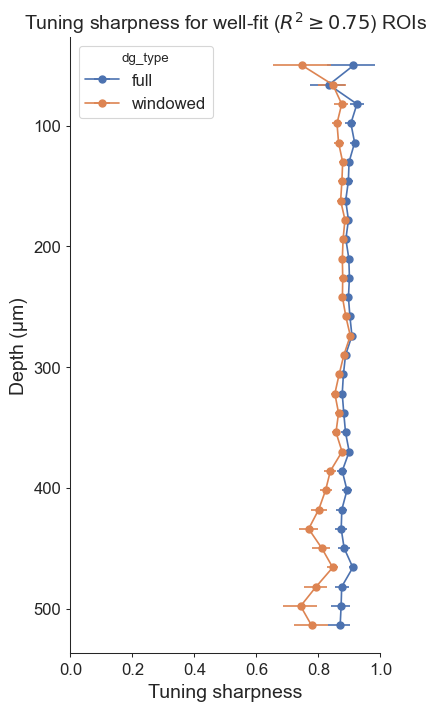

In [153]:
fig, ax = plt.subplots(figsize=(4, 8))

horiz_point_plot_ci(df[df.is_responsive & (df.tuning_r2 >= 0.5)], x="tuning_sharpness", y="depth", hue="dg_type", ax=ax)

ax.set_xlim(0, 1)
ax.invert_yaxis()
ax.set_title("Tuning sharpness for well-fit ($R^2 \geq 0.75$) ROIs")
ax.set_xlabel("Tuning sharpness")
ax.set_ylabel("Depth (µm)")

Text(0, 0.5, 'Depth (µm)')

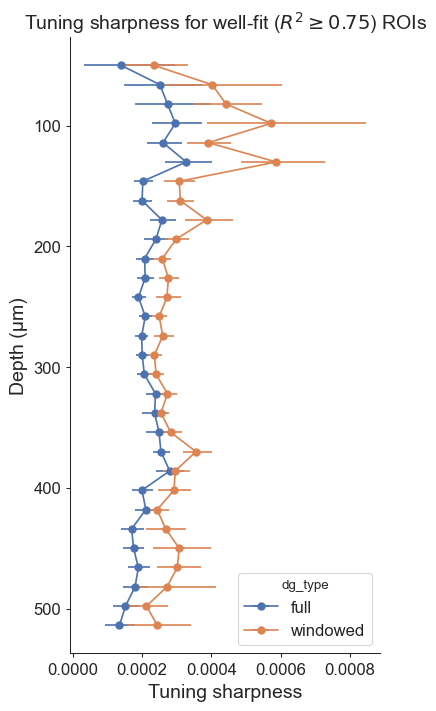

In [161]:
fig, ax = plt.subplots(figsize=(4, 8))
r2_thresh = 0.5

horiz_point_plot_ci(df[df.is_responsive & (df.tuning_r2 >= r2_thresh)], x="tuning_k", y="depth", hue="dg_type", ax=ax)

# ax.set_xlim(0, 1)
ax.invert_yaxis()
ax.set_title(f"Tuning sharpness for well-fit ($R^2 \geq {r2_thresh}$) ROIs")
ax.set_xlabel("Tuning sharpness")
ax.set_ylabel("Depth (µm)")